In [ ]:
# Upgrade Oracle ADS to pick up the latest preview version to maintain compatibility with Oracle Cloud Infrastructure.

!odsc conda install --uri https://objectstorage.us-ashburn-1.oraclecloud.com/n/bigdatadatasciencelarge/b/service-conda-packs-fs/o/service_pack/cpu/PySpark_3.2_and_Feature_Store/1.0/fspyspark32_p38_cpu_v1#conda

Oracle Data Science service sample notebook.

Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">Feature store handling querying operations</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:
---
Managing many datasets, data-sources and transformations for machine learning is complex and costly. Poorly cleaned data, data issues, bugs in transformations, data drift and training serving skew all leads to increased model development time and worse model performance. Here, feature store is well positioned to solve many of the problems since it provides a centralised way to transform and access data for training and serving time and helps defines a standardised pipeline for ingestion of data and querying of data. This notebook demonstrates how to use feature store within a long lasting [Oracle Cloud Infrastructure Data Flow](https://docs.oracle.com/en-us/iaas/data-flow/using/home.htm) cluster.

Compatible conda pack: [PySpark 3.2 and Feature store](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8

## Contents:

- <a href="#concepts">1. Introduction</a>
- <a href='#pre-requisites'>1. Pre-requisites</a>
    - <a href='#policies'>2.1 Policies</a>
    - <a href='#prerequisites_authentication'>2.2 Authentication</a>
    - <a href='#prerequisites_variables'>2.3 Variables</a>
- <a href='#featurestore_querying'>3. Feature store querying</a>
    - <a href='#data_exploration'>3.1. Exploration of data in feature store</a>
    - <a href='#load_featuregroup'>3.2. Load feature groups</a>
    - <a href='#explore_featuregroup'>3.3. Explore feature groups</a>
    - <a href='#select_subset_featuregroup'>3.4. Select subset of features</a>
    - <a href='#filter_featuregroup'>3.5. Filter feature groups</a>
    - <a href='#join_featuregroup'>3.6. Apply joins on feature group</a>
    - <a href='#create_dataset'>3.7. Create dataset from multiple or one feature group</a>
    - <a href='#sql_query'>3.8 Free form sql query</a>
- <a href='#ref'>4. References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

<a id="concepts"></a>
# 1. Introduction

Oracle feature store is a stack based solution that is deployed in the customer enclave using OCI resource manager. Customer can stand up the service with infrastructure in their own tenancy. The service consists of API which are deployed in customer tenancy using resource manager.

The following are some key terms that will help you understand OCI Data Science Feature Store:


* **Feature Vector**: Set of feature values for any one primary/identifier key. Eg. All/subset of features of customer id ‘2536’ can be called as one feature vector.

* **Feature**: A feature is an individual measurable property or characteristic of a phenomenon being observed.

* **Entity**: An entity is a group of semantically related features. The first step a consumer of features would typically do when accessing the feature store service is to list the entities and the entities associated features. Another way to look at it is that an entity is an object or concept that is described by its features. Examples of entities could be customer, product, transaction, review, image, document, etc.

* **Feature Group**: A feature group in a feature store is a collection of related features that are often used together in ml models. It serves as an organizational unit within the feature store for users to manage, version and share features across different ml projects. By organizing features into groups, data scientists and ml engineers can efficiently discover, reuse and collaborate on features reducing the redundant work and ensuring consistency in feature engineering.

* **Feature Group Job**: Feature group job is the execution instance of a feature group. Each feature group job will include validation results and statistics results.

* **Dataset**: A dataset is a collection of feature that are used together to either train a model or perform model inference.

* **Dataset Job**: Dataset job is the execution instance of a dataset. Each dataset job will include validation results and statistics results.

<a id='pre-requisites'></a>
# 2. Pre-requisites

Data Flow Sessions are accessible through the following conda environment:

* **PySpark 3.2, Feature store 1.0 and Data Flow 1.0 (fs_pyspark32_p38_cpu_v1)**

The [Data Catalog Hive Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm) provides schema definitions for objects in structured and unstructured data assets. The Metastore is the central metadata repository to understand tables backed by files on object storage. You can customize `fs_pyspark32_p38_cpu_v1`, publish it, and use it as a runtime environment for a Data Flow session cluster. The metastore id of hive metastore is tied to feature store construct of feature store service.


<a id='setup_spark-defaults'></a>
### `spark-defaults.conf`

The `spark-defaults.conf` file is used to define the properties that are used by Spark. A templated version is installed when you install a Data Science conda environment that supports PySpark. However, you must update the template so that the Data Catalog metastore can be accessed. You can do this manually. However, the `odsc data-catalog config` commandline tool is ideal for setting up the file because it gathers information about your environment, and uses that to build the file.

The `odsc data-catalog config` command line tool needs the `--metastore` option to define the Data Catalog metastore OCID. No other command line option is needed because settings have default values, or they take values from your notebook session environment. Following are common parameters that you may need to override.

The `--authentication` option sets the authentication mode. It supports resource principal and API keys. The preferred method for authentication is resource principal, which is sent with `--authentication resource_principal`. If you want to use API keys, then use the `--authentication api_key` option. If the `--authentication` isn't specified, API keys are used. When API keys are used, information from the OCI configuration file is used to create the `spark-defaults.conf` file.

Object Storage and Data Catalog are regional services. By default, the region is set to the region your notebook session is running in. This information is taken from the environment variable, `NB_REGION`. Use the `--region` option to override this behavior.

The default location of the `spark-defaults.conf` file is `/home/datascience/spark_conf_dir` as defined in the `SPARK_CONF_DIR` environment variable. Use the `--output` option to define the directory where to write the file.

You need to determine what settings are appropriate for your configuration. However, the following works for most configurations and is run in a terminal window.

```bash
odsc data-catalog config --authentication resource_principal --metastore <metastore_id>
```
For more assistance, use the following command in a terminal window:

```bash
odsc data-catalog config --help
```

<a id='setup_session'></a>
### Session Setup

The notebook makes connections to the Data Catalog metastore and Object Storage. In the next cell, specify the bucket URI to act as the data warehouse. Use the `warehouse_uri` variable with the `oci://<bucket_name>@<namespace_name>/<key>` format. Update the variable `metastore_id` with the OCID of the Data Catalog metastore.

<a id='policies'></a>
### 2.1. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
* [Data Catalog Metastore Required Policies](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)
* [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)

<a id="prerequisites_authentication"></a>
### 2.2. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the notebook cluster.<br>
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```.

In [1]:
import ads
ads.set_auth(auth="resource_principal", client_kwargs={"service_endpoint": "<api_gateway_endpoint>"})

<a id="prerequisites_variables"></a>
### 2.3. Variables
To run this notebook, you must provide some information about your tenancy configuration. To create and run a feature store, you must specify a `<compartment_id>` and bucket `<metastore_id>` for offline feature store.

In [2]:
import os

compartment_id = "<compartment_id>"
metastore_id = "<metastore_id>"

<a id="featurestore_querying"></a>
# 3. Feature group querying
By default the **PySpark 3.2, Feature store and Data Flow** conda environment includes pre-installed [great-expectations](https://legacy.docs.greatexpectations.io/en/latest/reference/core_concepts/validation.html) and [deeque](https://github.com/awslabs/deequ) libraries. The joining functionality is heavily inspired by the APIs used by Pandas to merge, join or filter DataFrames. The APIs allow you to specify which features to select from which feature group, how to join them and which features to use in join conditions.

In [3]:
import warnings
warnings.filterwarnings("ignore", message="iteritems is deprecated")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
import pandas as pd
from ads.feature_store.feature_store import FeatureStore
from ads.feature_store.feature_group import FeatureGroup
from ads.feature_store.model_details import ModelDetails
from ads.feature_store.dataset import Dataset
from ads.feature_store.common.enums import DatasetIngestionMode

from ads.feature_store.feature_group_expectation import ExpectationType
from great_expectations.core import ExpectationSuite, ExpectationConfiguration
from ads.feature_store.feature_store_registrar import FeatureStoreRegistrar

  from .model_deployment_properties import ModelDeploymentProperties

  from .model_deployer import ModelDeployer

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  LooseVersion(pyarrow.__version__) >= LooseVersion("2.0.0")

  if LooseVersion(pd.__version__) >= LooseVersion("0.24"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) >= LooseVersion("1.3.0"):

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore

Implementing implicit na

<a id="data_exploration"></a>
### 3.1. Exploration of data in feature store

In [5]:
flights_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/flights.csv")[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
flights_df = flights_df.head(100)
flights_df.head()

  flights_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/flights.csv")[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]



,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,2015,1,1,4,AS,98,ANC,SEA
1,2015,1,1,4,AA,2336,LAX,PBI
2,2015,1,1,4,US,840,SFO,CLT
3,2015,1,1,4,AA,258,LAX,MIA
4,2015,1,1,4,AS,135,SEA,ANC


In [6]:
airports_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/airports.csv")
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [7]:
airlines_df = pd.read_csv("https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/data/flights/airlines.csv")
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


<a id="load_featuregroup"></a>
### 3.2. Create feature store logical entities

#### 3.2.1 Feature Store
Feature store is the top level entity for feature store service

In [8]:
feature_store_resource = (
    FeatureStore().
    with_description("Data consisting of flights").
    with_compartment_id(compartment_id).
    with_display_name("flights details").
    with_offline_config(metastore_id=metastore_id)
)

<a id="create_feature_store"></a>
##### Create Feature Store

Call the ```.create()``` method of the Feature store instance to create a feature store.

In [9]:
feature_store = feature_store_resource.create()
feature_store


kind: featurestore
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a
  description: Data consisting of flights
  displayName: flights details
  id: 751D665EB6AE7360928F15705F9F0F48
  offlineConfig:
    metastoreId: ocid1.datacatalogmetastore.oc1.iad.amaaaaaanif7xwiaavhd2liaebamr3tbjzio3uw2lxuteoa5ejsfvhqufbsa
type: featureStore

#### 3.2.2 Entity
An entity is a group of semantically related features.

In [10]:
entity = feature_store.create_entity(
    display_name="Flight details2",
    description="description for flight details"
)
entity


kind: entity
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a
  description: description for flight details
  featureStoreId: 751D665EB6AE7360928F15705F9F0F48
  id: 843E320A28F319748425787F04BCD3B8
  name: Flight details2
type: entity

#### 3.2.3 Feature group
A feature group is an object that represents a logical group of time-series feature data as it is found in a datasource.

<a id="create_feature_group_flights"></a>
##### Flights Feature Group

Create feature group for flights

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/feature_group_flights.gif" width="700" height="350" />
</div>

In [11]:
feature_group_flights = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["FLIGHT_NUMBER"])
    .with_name("flights_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(flights_df)
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023/07/14 04:29:29 NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



In [12]:
feature_group_flights.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a
  entityId: 843E320A28F319748425787F04BCD3B8
  featureStoreId: 751D665EB6AE7360928F15705F9F0F48
  id: C24E858807F4EBA22BF14C08B9A6E2DD
  inputFeatureDetails:
  - featureType: LONG
    name: YEAR
    orderNumber: 1
  - featureType: LONG
    name: MONTH
    orderNumber: 2
  - featureType: LONG
    name: DAY
    orderNumber: 3
  - featureType: LONG
    name: DAY_OF_WEEK
    orderNumber: 4
  - featureType: STRING
    name: AIRLINE
    orderNumber: 5
  - featureType: LONG
    name: FLIGHT_NUMBER
    orderNumber: 6
  - featureType: STRING
    name: ORIGIN_AIRPORT
    orderNumber: 7
  - featureType: STRING
    name: DESTINATION_AIRPORT
    orderNumber: 8
  isInferSchema: true
  name: flights_feature_group
  primaryKeys:
    items:
    - name: FLIGHT_NUMBER
  statisticsConfig:
    isEnabled: true
type: featureGroup

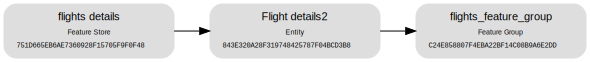

In [13]:
feature_group_flights.show()

In [14]:
feature_group_flights.materialise(flights_df)

Hive Session ID = 59994193-ab1d-4749-8d21-17cc661a95c6


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow


/home/datascience/conda/fspyspark32_p38_cpu#conda_v1/lib/python3.8/site-packages/mlm_insights/core/sfcs/descriptive_statistics_sfc.py:80: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  self.central_moments = [moment(column, moment=i) for i in range(MAXIMUM_MOMENT_ORDER + 1)]
/home/datascience/conda/fspyspark32_p38_cpu#conda_v1/lib/python3.8/site-packages/mlm_insights/core/sfcs/descriptive_statistics_sfc.py:80: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  self.central_moments = [moment(column, moment=i) for i in range(MAXIMUM_MOMENT_ORDER + 1)]
/home/datascience/conda/fspyspark32_p38_cpu#conda_v1/lib/python3.8/site-packages/mlm_insights/core/sfcs/descriptive_statistics_sfc.py:80: RuntimeWarning: Precision loss occurred in moment calculat

INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f8ef9399bf0>), 'c19e3960aa08a392d20aaa5da607d9ea': DescriptiveStatisticsSFC(total_count=100.0, mean=2015.0, minimum=2015.0, maximum=2015.0, central_moments=[1.0, 0.0, 0.0, 0.0, 0.0]), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f8ef9399d70>), '6e3ac490990d92bca69c828fe3aff8ad': QuantilesSFC(kll_sketch=<_datasketches.kll_doubles_sketch object at 0x7f8ef9399cf0>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f8ef9203930>), 'c19e3960aa08a392d20aaa5da607d9ea': DescriptiveStatisticsSFC(total_count=100.0, mean=1.0, minimum=1.0, maximum=1.0, central_moments=[1.0, 0.0, 0.0, 0.0, 0.0]), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_

INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.descriptive_statistics_sfc.DescriptiveStatisticsSFC'>, config={}) sfc from sfc meta data
INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.descriptive_statistics_sfc.DescriptiveStatisticsSFC'>, config={}) sfc from sfc meta data
INFO:mlm_insights.core.metrics:Calculated Kurtosis metric, value: None
INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.descriptive_statistics_sfc.DescriptiveStatisticsSFC'>, config={}) sfc from sfc meta data
INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.descriptive_statistics_sfc.DescriptiveStatisticsSFC'>, config={}) sfc from sfc meta data
INFO:mlm_insights.core.metrics:Calculated Skewness metric, value: None
INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.descriptive_statistics_sfc.DescriptiveStatisticsSFC'>, config={}) sfc from sf

<a id="create_feature_group_airport"></a>
##### Airport Feature Group

Create feature group for airport

In [15]:
expectation_suite_airports = ExpectationSuite(
    expectation_suite_name="test_airports_df"
)
expectation_suite_airports.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "IATA_CODE"},
    )
)
expectation_suite_airports.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={"column": "LATITUDE", "min_value": -1.0, "max_value": 1.0},
    )
)

expectation_suite_airports.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_be_between",
        kwargs={"column": "LONGITUDE", "min_value": -1.0, "max_value": 1.0},
    )
)

{"meta": {}, "expectation_type": "expect_column_values_to_be_between", "kwargs": {"column": "LONGITUDE", "min_value": -1.0, "max_value": 1.0}}

In [16]:
feature_group_airports = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["IATA_CODE"])
    .with_name("airport_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(airports_df)
    .with_expectation_suite(
        expectation_suite=expectation_suite_airports,
        expectation_type=ExpectationType.LENIENT,
     )
)

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



In [17]:
feature_group_airports.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a
  entityId: 843E320A28F319748425787F04BCD3B8
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: IATA_CODE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    - arguments:
        column: LATITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-1
      ruleType: expect_column_values_to_be_between
    - arguments:
        column: LONGITUDE
        max_value: 1.0
        min_value: -1.0
      levelType: ERROR
      name: Rule-2
      ruleType: expect_column_values_to_be_between
    expectationType: LENIENT
    name: test_airports_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: 751D665EB6AE7360928F15705F9F0F48
  id: C1771CFDA79A082BB9FB85D9E5FCB192
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - feat

In [18]:
feature_group_airports.materialise(airports_df)

INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│      LENIENT       │            3             │             1             │              2              │      33.3333      │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════════════════════════════════════╤═══

INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f8ef9584e30>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f8efbe47830>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f8ef9584930>), '4cd1d3704778a196571a6c83581854cc': D

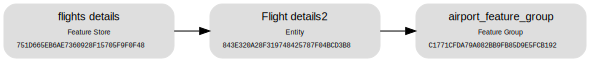

In [19]:
feature_group_airports.show()

<a id="create_feature_group_airlines"></a>
##### Airlines Feature Group

Create feature group for airlines

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/feature_groups.gif" width="700" height="350" />
</div>

In [20]:
expectation_suite_airlines = ExpectationSuite(
    expectation_suite_name="test_airlines_df"
)
expectation_suite_airlines.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "IATA_CODE"},
    )
)

{"meta": {}, "expectation_type": "expect_column_values_to_not_be_null", "kwargs": {"column": "IATA_CODE"}}

In [21]:
feature_group_airlines = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["IATA_CODE"])
    .with_name("airlines_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(airlines_df)
    .with_expectation_suite(
        expectation_suite=expectation_suite_airlines,
        expectation_type=ExpectationType.STRICT,
     )
)

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



In [22]:
feature_group_airlines.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a
  entityId: 843E320A28F319748425787F04BCD3B8
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: IATA_CODE
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    expectationType: STRICT
    name: test_airlines_df
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: 751D665EB6AE7360928F15705F9F0F48
  id: 4E21D2D878A101E8804837CAD6499FD9
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - featureType: STRING
    name: AIRLINE
    orderNumber: 2
  isInferSchema: true
  name: airlines_feature_group
  primaryKeys:
    items:
    - name: IATA_CODE
  statisticsConfig:
    isEnabled: true
type: featureGroup

In [23]:
feature_group_airlines.materialise(airlines_df)

INFO:great_expectations.validator.validator:	1 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│       STRICT       │            1             │             1             │              0              │        100        │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤═════════════════════════╤══════════╕
│              rule_type    

INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f8ef956b670>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f8ef956b430>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f8ef95cdc30>), '4cd1d3704778a196571a6c83581854cc': D

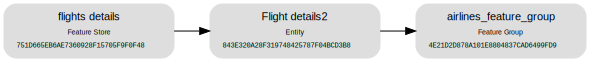

In [24]:
feature_group_airlines.show()

<a id="explore_featuregroup"></a>
### 3.3. Explore feature groups

In [25]:
feature_group_flights.get_features_df()

,name,type,feature_group_id
0,YEAR,LONG,C24E858807F4EBA22BF14C08B9A6E2DD
1,MONTH,LONG,C24E858807F4EBA22BF14C08B9A6E2DD
2,DAY,LONG,C24E858807F4EBA22BF14C08B9A6E2DD
3,DAY_OF_WEEK,LONG,C24E858807F4EBA22BF14C08B9A6E2DD
4,AIRLINE,STRING,C24E858807F4EBA22BF14C08B9A6E2DD
5,FLIGHT_NUMBER,LONG,C24E858807F4EBA22BF14C08B9A6E2DD
6,ORIGIN_AIRPORT,STRING,C24E858807F4EBA22BF14C08B9A6E2DD
7,DESTINATION_AIRPORT,STRING,C24E858807F4EBA22BF14C08B9A6E2DD


In [26]:
feature_group_airports.get_features_df()

,name,type,feature_group_id
0,IATA_CODE,STRING,C1771CFDA79A082BB9FB85D9E5FCB192
1,AIRPORT,STRING,C1771CFDA79A082BB9FB85D9E5FCB192
2,CITY,STRING,C1771CFDA79A082BB9FB85D9E5FCB192
3,STATE,STRING,C1771CFDA79A082BB9FB85D9E5FCB192
4,COUNTRY,STRING,C1771CFDA79A082BB9FB85D9E5FCB192
5,LATITUDE,DOUBLE,C1771CFDA79A082BB9FB85D9E5FCB192
6,LONGITUDE,DOUBLE,C1771CFDA79A082BB9FB85D9E5FCB192


In [27]:
feature_group_airlines.get_features_df()

,name,type,feature_group_id
0,IATA_CODE,STRING,4E21D2D878A101E8804837CAD6499FD9
1,AIRLINE,STRING,4E21D2D878A101E8804837CAD6499FD9


In [28]:
feature_group_flights.select().show()

+----+-----+---+-----------+-------+-------------+--------------+-------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+
|2015|    1|  1|          4|     B6|         1030|           BQN|                MCO|
|2015|    1|  1|          4|     B6|          262|           SJU|                BOS|
|2015|    1|  1|          4|     B6|         2134|           SJU|                MCO|
|2015|    1|  1|          4|     B6|          730|           BQN|                MCO|
|2015|    1|  1|          4|     B6|          768|           PSE|                MCO|
|2015|    1|  1|          4|     B6|         2276|           SJU|                BDL|
|2015|    1|  1|          4|     US|          602|           ORD|                PHX|
|2015|    1|  1|          4|     AS|          695|           GEG|                SEA|
|2015|    1|  1|          4|     HA|          102|    

In [29]:
feature_group_airports.select().show()

+---------+--------------------+-------------+-----+-------+--------+----------+
|IATA_CODE|             AIRPORT|         CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---------+--------------------+-------------+-----+-------+--------+----------+
|      ABE|Lehigh Valley Int...|    Allentown|   PA|    USA|40.65236|  -75.4404|
|      ABI|Abilene Regional ...|      Abilene|   TX|    USA|32.41132|  -99.6819|
|      ABQ|Albuquerque Inter...|  Albuquerque|   NM|    USA|35.04022|-106.60919|
|      ABR|Aberdeen Regional...|     Aberdeen|   SD|    USA|45.44906| -98.42183|
|      ABY|Southwest Georgia...|       Albany|   GA|    USA|31.53552| -84.19447|
|      ACK|Nantucket Memoria...|    Nantucket|   MA|    USA|41.25305| -70.06018|
|      ACT|Waco Regional Air...|         Waco|   TX|    USA|31.61129| -97.23052|
|      ACV|      Arcata Airport|Arcata/Eureka|   CA|    USA|40.97812|-124.10862|
|      ACY|Atlantic City Int...|Atlantic City|   NJ|    USA|39.45758| -74.57717|
|      ADK|        Adak Airp

In [30]:
feature_group_airlines.select().show()

+---------+--------------------+
|IATA_CODE|             AIRLINE|
+---------+--------------------+
|       NK|    Spirit Air Lines|
|       WN|Southwest Airline...|
|       DL|Delta Air Lines Inc.|
|       EV|Atlantic Southeas...|
|       HA|Hawaiian Airlines...|
|       MQ|American Eagle Ai...|
|       VX|      Virgin America|
|       UA|United Air Lines ...|
|       AA|American Airlines...|
|       US|     US Airways Inc.|
+---------+--------------------+
only showing top 10 rows



In [31]:
feature_group_airlines.get_statistics().to_pandas()

,IATA_CODE,AIRLINE
Count,"{'total_count': 14, 'missing_count': 0, 'missing_count_percentage': 0.0}","{'total_count': 14, 'missing_count': 0, 'missing_count_percentage': 0.0}"
TopKFrequentElements,"{'value': [{'value': 'UA', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'AA', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'NK', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'VX', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'OO', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'WN', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'US', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'DL', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'AS', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'B6', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}]}","{'value': [{'value': 'Skywest Airlines Inc.', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'American Eagle Airlines Inc.', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'Frontier Airlines Inc.', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'Atlantic Southeast Airlines', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'Southwest Airlines Co.', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'Hawaiian Airlines Inc.', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'American Airlines Inc.', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'Virgin America', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'Spirit Air Lines', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}, {'value': 'JetBlue Airways', 'estimate': 1, 'lower_bound': 1, 'upper_bound': 1}]}"
TypeMetric,"{'string_type_count': 14, 'integral_type_count': 0, 'fractional_type_count': 0, 'boolean_type_count': 0}","{'string_type_count': 14, 'integral_type_count': 0, 'fractional_type_count': 0, 'boolean_type_count': 0}"
DuplicateCount,"{'count': 0, 'percentage': 0.0}","{'count': 0, 'percentage': 0.0}"
Mode,"{'value': ['UA', 'AA']}","{'value': ['Skywest Airlines Inc.', 'American Eagle Airlines Inc.']}"
DistinctCount,{'value': 14},{'value': 14}


In [32]:
feature_group_flights.get_statistics().to_pandas()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT
Skewness,{'value': None},{'value': None},{'value': None},{'value': None},NaN,{'value': 1.545298800400988},NaN,NaN
StandardDeviation,{'value': 0.0},{'value': 0.0},{'value': 0.0},{'value': 0.0},NaN,{'value': 1873.257011170651},NaN,NaN
Min,{'value': 2015.0},{'value': 1.0},{'value': 1.0},{'value': 4.0},NaN,{'value': 17.0},NaN,NaN
IsConstantFeature,{'value': True},{'value': True},{'value': True},{'value': True},NaN,{'value': False},NaN,NaN
IQR,{'value': 0.0},{'value': 0.0},{'value': 0.0},{'value': 0.0},NaN,{'value': 1905.0},NaN,NaN
Range,{'value': 0.0},{'value': 0.0},{'value': 0.0},{'value': 0.0},NaN,{'value': 7402.0},NaN,NaN
ProbabilityDistribution,"{'bins': [2015.0], 'density': [1.0]}","{'bins': [1.0], 'density': [1.0]}","{'bins': [1.0], 'density': [1.0]}","{'bins': [4.0], 'density': [1.0]}",NaN,"{'bins': [17.0, 272.2413793103448, 527.4827586206897, 782.7241379310344, 1037.9655172413793, 1293.2068965517242, 1548.4482758620688, 1803.6896551724137, 2058.9310344827586, 2314.1724137931033, 2569.4137931034484, 2824.655172413793, 3079.8965517241377, 3335.137931034483, 3590.3793103448274, 3845.6206896551726, 4100.862068965517, 4356.103448275862, 4611.3448275862065, 4866.586206896552, 5121.827586206897, 5377.068965517241, 5632.310344827586, 5887.551724137931, 6142.793103448275, 6398.0344827586205, 6653.275862068966, 6908.517241379311, 7163.758620689655, 7419.0], 'density': [0.22, 0.1, 0.10999999999999902, 0.049999999999999004, 0.08999999999999901, 0.07, 0.04, 0.039999999999999, 0.04, 0.06999999999999901, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.01, 0.01, 0.01, 0.0, 0.030000000000000002, 0.039999999999999, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.02, 0.01]}",NaN,NaN
Variance,{'value': 0.0},{'value': 0.0},{'value': 0.0},{'value': 0.0},NaN,{'value': 3509091.8299000002},NaN,NaN
TypeMetric,"{'string_type_count': 0, 'integral_type_count': 100, 'fractional_type_count': 0, 'boolean_type_count': 0}","{'string_type_count': 0, 'integral_type_count': 100, 'fractional_type_count': 0, 'boolean_type_count': 0}","{'string_type_count': 0, 'integral_type_count': 100, 'fractional_type_count': 0, 'boolean_type_count': 0}","{'string_type_count': 0, 'integral_type_count': 100, 'fractional_type_count': 0, 'boolean_type_count': 0}","{'string_type_count': 100, 'integral_type_count': 0, 'fractional_type_count': 0, 'boolean_type_count': 0}","{'string_type_count': 0, 'integral_type_count': 100, 'fractional_type_count': 0, 'boolean_type_count': 0}","{'string_type_count': 100, 'integral_type_count': 0, 'fractional_type_count': 0, 'boolean_type_count': 0}","{'string_type_count': 100, 'integral_type_count': 0, 'fractional_type_count': 0, 'boolean_type_count': 0}"
FrequencyDistribution,"{'bins': [2015.0], 'frequency': [100]}","{'bins': [1.0], 'frequency': [100]}","{'bins': [1.0], 'frequency': [100]}","{'bins': [4.0], 'frequency': [100]}",NaN,"{'bins': [17.0, 272.2413793103448, 527.4827586206897, 782.7241379310344, 1037.9655172413793, 1293.2068965517242, 1548.4482758620688, 1803.6896551724137, 2058.9310344827586, 2314.1724137931033, 2569.4137931034484, 2824.655172413793, 3079.8965517241377, 3335.137931034483, 3590.3793103448274, 3845.6206896551726, 4100.862068965517, 4356.103448275862, 4611.3448275862065, 4866.586206896552, 5121.827586206897, 5377.068965517241, 5632.310344827586, 5887.551724137931, 6142.793103448275, 6398.0344827586205, 6653.275862068966, 6908.517241379311, 7163.758620689655, 7419.0], 'frequency': [22, 10, 11, 5, 9, 7, 4, 4, 4, 7, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 3, 4, 1, 0, 1, 0, 0, 0, 2, 1]}",NaN,NaN


In [33]:
feature_group_airlines.get_validation_output().to_pandas()

,0
results,"[{'exception_info': {'raised_exception': False, 'exception_traceback': None, 'exception_message': None}, 'meta': {}, 'result': {'element_count': 14, 'unexpected_count': 0, 'unexpected_percent': 0.0, 'partial_unexpected_list': []}, 'expectation_config': {'meta': {}, 'expectation_type': 'expect_column_values_to_not_be_null', 'kwargs': {'column': 'IATA_CODE', 'batch_id': '90bbaf1a6a4ae45a238e05e0d240a033'}}, 'success': True}]"
success,True
meta.great_expectations_version,0.15.39
meta.expectation_suite_name,airlines_feature_group
meta.run_id.run_time,2023-07-14T04:30:58.945832+00:00
meta.run_id.run_name,None
meta.batch_markers.ge_load_time,20230714T043058.944828Z
meta.active_batch_definition.datasource_name,feature-ingestion-pipeline
meta.active_batch_definition.data_connector_name,feature-ingestion-pipeline
meta.active_batch_definition.data_asset_name,feature-ingestion-pipeline


<a id="select_subset_featuregroup"></a>
### 3.4. Select subset of features

In [34]:
feature_group_airlines.select(['IATA_CODE']).show()

+---------+
|IATA_CODE|
+---------+
|       NK|
|       WN|
|       DL|
|       EV|
|       HA|
|       MQ|
|       VX|
|       UA|
|       AA|
|       US|
+---------+
only showing top 10 rows



<a id="filter_featuregroup"></a>
### 3.5. Filter feature groups

In [35]:
feature_group_airlines.filter(feature_group_airlines.IATA_CODE == "EV").show()

+---------+--------------------+
|IATA_CODE|             AIRLINE|
+---------+--------------------+
|       EV|Atlantic Southeas...|
+---------+--------------------+



<a id="join_featuregroup"></a>
### 3.6. Apply joins on feature group
As in Pandas, if the feature has the same name on both feature groups, then you can use the `on=[]` paramter. If they have different names, then you can use the `left_on=[]` and `right_on=[]` paramters:

In [36]:
from ads.feature_store.common.enums import JoinType

query = (
    feature_group_flights.select()
    .join(feature_group_airlines.select(), left_on=['ORIGIN_AIRPORT'], right_on=['IATA_CODE'], join_type=JoinType.LEFT)
    .join(feature_group_airports.select(), left_on=['AIRLINE'], right_on=['IATA_CODE'], join_type=JoinType.LEFT)
)
query.show(5)

+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|IATA_CODE|AIRPORT|CITY|STATE|COUNTRY|LATITUDE|LONGITUDE|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|2015|    1|  1|          4|     B6|         1030|           BQN|                MCO|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     B6|          262|           SJU|                BOS|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     B6|         2134|           SJU|                MCO|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     B6|          730|           BQN|                MCO|     null|   null|null| null|   null|    null|     null|
|2015|

In [37]:
query.to_string()

'SELECT fg_2.YEAR YEAR, fg_2.MONTH MONTH, fg_2.DAY DAY, fg_2.DAY_OF_WEEK DAY_OF_WEEK, fg_2.AIRLINE AIRLINE, fg_2.FLIGHT_NUMBER FLIGHT_NUMBER, fg_2.ORIGIN_AIRPORT ORIGIN_AIRPORT, fg_2.DESTINATION_AIRPORT DESTINATION_AIRPORT, fg_0.IATA_CODE IATA_CODE, fg_1.AIRPORT AIRPORT, fg_1.CITY CITY, fg_1.STATE STATE, fg_1.COUNTRY COUNTRY, fg_1.LATITUDE LATITUDE, fg_1.LONGITUDE LONGITUDE FROM `843E320A28F319748425787F04BCD3B8`.flights_feature_group fg_2 LEFT JOIN `843E320A28F319748425787F04BCD3B8`.airlines_feature_group fg_0 ON fg_2.ORIGIN_AIRPORT = fg_0.IATA_CODE LEFT JOIN `843E320A28F319748425787F04BCD3B8`.airport_feature_group fg_1 ON fg_0.AIRLINE = fg_1.IATA_CODE'

<a id="create_dataset"></a>
### 3.7 Create dataset
A dataset is a collection of feature snapshots that are joined together to either train a model or perform model inference.

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/dataset.gif" width="700" height="350" />
</div>

In [38]:
dataset = (
    Dataset()
    .with_description("Combined dataset for flights")
    .with_compartment_id(compartment_id)
    .with_name("flights_dataset")
    .with_entity_id(entity.id)
    .with_feature_store_id(feature_store.id)
    .with_query(query.to_string())
)

<a id="create_dataset"></a>
##### Create Dataset

Call the ```.create()``` method of the Dataset instance to create a dataset.

In [39]:
dataset.create()


kind: Dataset
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a
  description: Combined dataset for flights
  entityId: 843E320A28F319748425787F04BCD3B8
  featureStoreId: 751D665EB6AE7360928F15705F9F0F48
  id: 6881C3E17FC9BBB02934BB7B6B9068D1
  name: flights_dataset
  query: SELECT fg_2.YEAR YEAR, fg_2.MONTH MONTH, fg_2.DAY DAY, fg_2.DAY_OF_WEEK DAY_OF_WEEK,
    fg_2.AIRLINE AIRLINE, fg_2.FLIGHT_NUMBER FLIGHT_NUMBER, fg_2.ORIGIN_AIRPORT ORIGIN_AIRPORT,
    fg_2.DESTINATION_AIRPORT DESTINATION_AIRPORT, fg_0.IATA_CODE IATA_CODE, fg_1.AIRPORT
    AIRPORT, fg_1.CITY CITY, fg_1.STATE STATE, fg_1.COUNTRY COUNTRY, fg_1.LATITUDE
    LATITUDE, fg_1.LONGITUDE LONGITUDE FROM `843E320A28F319748425787F04BCD3B8`.flights_feature_group
    fg_2 LEFT JOIN `843E320A28F319748425787F04BCD3B8`.airlines_feature_group fg_0
    ON fg_2.ORIGIN_AIRPORT = fg_0.IATA_CODE LEFT JOIN `843E320A28F319748425787F04BCD3B8`.airport_feature_group
    fg_1 ON fg_0.AIRLIN

In [40]:
dataset.materialise()

INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



/home/datascience/conda/fspyspark32_p38_cpu#conda_v1/lib/python3.8/site-packages/mlm_insights/core/sfcs/descriptive_statistics_sfc.py:80: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  self.central_moments = [moment(column, moment=i) for i in range(MAXIMUM_MOMENT_ORDER + 1)]
/home/datascience/conda/fspyspark32_p38_cpu#conda_v1/lib/python3.8/site-packages/mlm_insights/core/sfcs/descriptive_statistics_sfc.py:80: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  self.central_moments = [moment(column, moment=i) for i in range(MAXIMUM_MOMENT_ORDER + 1)]
/home/datascience/conda/fspyspark32_p38_cpu#conda_v1/lib/python3.8/site-packages/mlm_insights/core/sfcs/descriptive_statistics_sfc.py:80: RuntimeWarning: Precision loss occurred in moment calculat

INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f8ef9c31570>), 'c19e3960aa08a392d20aaa5da607d9ea': DescriptiveStatisticsSFC(total_count=100.0, mean=2015.0, minimum=2015.0, maximum=2015.0, central_moments=[1.0, 0.0, 0.0, 0.0, 0.0]), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f8ef9c31270>), '6e3ac490990d92bca69c828fe3aff8ad': QuantilesSFC(kll_sketch=<_datasketches.kll_doubles_sketch object at 0x7f8ef9589030>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f8ef9590f30>), 'c19e3960aa08a392d20aaa5da607d9ea': DescriptiveStatisticsSFC(total_count=100.0, mean=1.0, minimum=1.0, maximum=1.0, central_moments=[1.0, 0.0, 0.0, 0.0, 0.0]), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_

INFO:mlm_insights.core.metrics:Calculated IsConstantFeature metric, value: True
INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.quantiles_sfc.QuantilesSFC'>, config={}) sfc from sfc meta data
INFO:mlm_insights.core.sfcs:getting quantiles from sketch for rank 0.75
INFO:mlm_insights.core.sfcs:getting quantiles from sketch for rank 0.25
INFO:mlm_insights.core.metrics:Calculated IQR metric, value: 0.0
INFO:mlm_insights.core.sfcs:getting quantiles from sketch for rank 0.75
INFO:mlm_insights.core.sfcs:getting quantiles from sketch for rank 0.25
INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.descriptive_statistics_sfc.DescriptiveStatisticsSFC'>, config={}) sfc from sfc meta data
INFO:mlm_insights.core.metrics:Calculated Range metric, value: 0.0
INFO:mlm_insights.core.sfcs:getting SFCMetaData(klass=<class 'mlm_insights.core.sfcs.quantiles_sfc.QuantilesSFC'>, config={}) sfc from sfc meta data
INFO:mlm_insights.core.metri

### Interoperability with model

In [41]:
model_details = ModelDetails().with_items(["ocid1.modelcatalog.oc1.unique_ocid"])
dataset.with_model_details(model_details)


kind: Dataset
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a
  description: Combined dataset for flights
  entityId: 843E320A28F319748425787F04BCD3B8
  featureStoreId: 751D665EB6AE7360928F15705F9F0F48
  id: 6881C3E17FC9BBB02934BB7B6B9068D1
  jobId: f8a347ca-db9a-4ba6-adbf-c3a5f0c61441
  modelDetails:
    items:
    - ocid1.modelcatalog.oc1.unique_ocid
  name: flights_dataset
  outputFeatureDetails:
    items:
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      featureType: LONG
      name: YEAR
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      featureType: LONG
      name: MONTH
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      featureType: LONG
      name: DAY
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      featureType: LONG
      name: DAY_OF_WEEK
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      featureType: STRING
      name: AIRLINE
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      feature

In [42]:
dataset.update()


kind: Dataset
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a
  description: Combined dataset for flights
  entityId: 843E320A28F319748425787F04BCD3B8
  featureStoreId: 751D665EB6AE7360928F15705F9F0F48
  id: 6881C3E17FC9BBB02934BB7B6B9068D1
  jobId: f8a347ca-db9a-4ba6-adbf-c3a5f0c61441
  modelDetails:
    items:
    - ocid1.modelcatalog.oc1.unique_ocid
  name: flights_dataset
  outputFeatureDetails:
    items:
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      featureType: LONG
      name: YEAR
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      featureType: LONG
      name: MONTH
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      featureType: LONG
      name: DAY
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      featureType: LONG
      name: DAY_OF_WEEK
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      featureType: STRING
      name: AIRLINE
    - datasetId: 6881C3E17FC9BBB02934BB7B6B9068D1
      feature

<a id="visualise_lineage"></a>
##### Visualise lineage

Use the ```.show()``` method on the Dataset instance to visualize the lineage of the dataset.

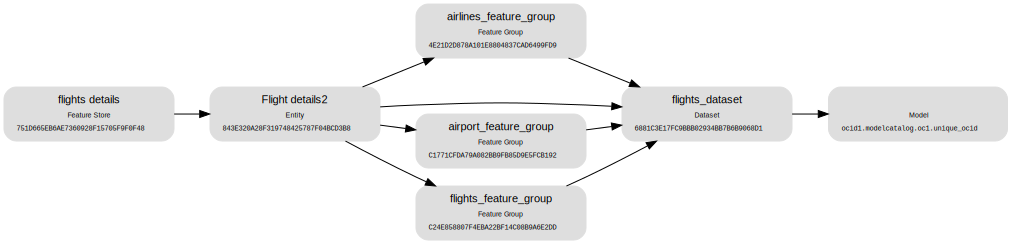

In [43]:
dataset.show()

In [44]:
dataset.profile().show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+
|format|                  id|                name|description|            location|           createdAt|       lastModified|partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|
+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+
| delta|7b4825ef-5a04-4fb...|843e320a28f319748...|       null|oci://default-sto...|2023-07-14 04:31:...|2023-07-14 04:32:11|              []|       2|       9038|        {}|               1|               2|
+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+------

In [45]:
dataset.preview().show()

+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|IATA_CODE|AIRPORT|CITY|STATE|COUNTRY|LATITUDE|LONGITUDE|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|2015|    1|  1|          4|     B6|         1030|           BQN|                MCO|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     B6|          262|           SJU|                BOS|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     B6|         2134|           SJU|                MCO|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     B6|          730|           BQN|                MCO|     null|   null|null| null|   null|    null|     null|
|2015|

<a id="sql_query"></a>
### 3.8  Freeform SQL query
Feature store provides a way to query feature store using free flow query. User need to mention `entity id` as the database name and `feature group name` as the table name to query feature store. This functionality can be useful if you need to express more complex queries for your use case

In [46]:
entity_id = entity.id

sql = (f"SELECT flights_feature_group.*, airport_feature_group.IATA_CODE "
       f"FROM `{entity_id}`.flights_feature_group flights_feature_group "
       f"LEFT JOIN `{entity_id}`.airport_feature_group airport_feature_group "
       f"ON flights_feature_group.ORIGIN_AIRPORT=airport_feature_group.IATA_CODE")

In [47]:
feature_store.sql(sql).show()

+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|IATA_CODE|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+
|2015|    1|  1|          4|     B6|         1030|           BQN|                MCO|      BQN|
|2015|    1|  1|          4|     B6|          262|           SJU|                BOS|      SJU|
|2015|    1|  1|          4|     B6|         2134|           SJU|                MCO|      SJU|
|2015|    1|  1|          4|     B6|          730|           BQN|                MCO|      BQN|
|2015|    1|  1|          4|     B6|          768|           PSE|                MCO|      PSE|
|2015|    1|  1|          4|     B6|         2276|           SJU|                BDL|      SJU|
|2015|    1|  1|          4|     US|          602|           ORD|                PHX|      ORD|
|2015|    1|  1|          4|     AS|    

In [48]:
feature_store_yaml = """
apiVersion: v1
kind: featureStore
spec:
  displayName: Flights feature store
  compartmentId: "<compartment_id>"
  offlineConfig:
    metastoreId: "<metastore_id>"

  entity: &flights_entity
    - kind: entity
      spec:
        name: Flights

  featureGroup:
    - kind: featureGroup
      spec:
        entity: *flights_entity
        name: flights_feature_group
        primaryKeys:
          - IATA_CODE
        inputFeatureDetails:
          - featureType: STRING
            name: IATA_CODE
            orderNumber: 1
          - featureType: STRING
            name: AIRPORT
            orderNumber: 2
          - featureType: STRING
            name: CITY
            orderNumber: 3
          - featureType: STRING
            name: STATE
            orderNumber: 4
          - featureType: STRING
            name: COUNTRY
            orderNumber: 5
          - featureType: FLOAT
            name: LATITUDE
            orderNumber: 6
          - featureType: FLOAT
            name: LONGITUDE
            orderNumber: 7
    - kind: featureGroup
      spec:
        entity: *flights_entity
        name: airlines_feature_group
        primaryKeys:
          - IATA_CODE
        inputFeatureDetails:
          - featureType: STRING
            name: IATA_CODE
            orderNumber: 1
          - featureType: STRING
            name: AIRPORT
            orderNumber: 2
          - featureType: STRING
            name: CITY
            orderNumber: 3
          - featureType: STRING
            name: STATE
            orderNumber: 4
          - featureType: STRING
            name: COUNTRY
            orderNumber: 5
          - featureType: FLOAT
            name: LATITUDE
            orderNumber: 6
          - featureType: FLOAT
            name: LONGITUDE
            orderNumber: 7

    - kind: featureGroup
      spec:
        entity: *flights_entity
        name: airport_feature_group
        primaryKeys:
          - IATA_CODE
        inputFeatureDetails:
          - featureType: STRING
            name: IATA_CODE
            orderNumber: 1
          - featureType: STRING
            name: AIRLINE
            orderNumber: 2
  dataset:
    - kind: dataset
      spec:
        name: flights_dataset
        entity: *flights_entity
        description: "Dataset for flights"
        query: 'SELECT flight.IATA_CODE, flight.AIRPORT FROM flights_feature_group flight'
"""

In [49]:
registrar = FeatureStoreRegistrar.from_yaml(yaml_string=feature_store_yaml)
registrar.create()

loop1:   0%|          | 0/6 [00:00<?, ?it/s]

Successfully created 1 entities, 0 transformations, 3 feature groups and 1 datasets


(
 kind: featurestore
 spec:
   compartmentId: ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a
   dataset:
   - kind: dataset
     spec:
       description: Dataset for flights
       entity: &id001
       - kind: entity
         spec:
           name: Flights
       name: flights_dataset
       query: SELECT flight.IATA_CODE, flight.AIRPORT FROM flights_feature_group flight
   displayName: Flights feature store
   entity: *id001
   featureGroup:
   - kind: featureGroup
     spec:
       entity: *id001
       inputFeatureDetails:
       - featureType: STRING
         name: IATA_CODE
         orderNumber: 1
       - featureType: STRING
         name: AIRPORT
         orderNumber: 2
       - featureType: STRING
         name: CITY
         orderNumber: 3
       - featureType: STRING
         name: STATE
         orderNumber: 4
       - featureType: STRING
         name: COUNTRY
         orderNumber: 5
       - featureType: FLOAT
         name: LATITUDE
   

<a id='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)